#  Defend against augmentation attacks in face recognition models

In [1]:
'''General packages'''

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import sklearn
import cv2
from PIL import Image
import os
import time
from tqdm import *

import torch
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms
import glob
from datetime import datetime
import argparse
torch.manual_seed(42)


In [9]:
! git clone https://github.com/shellyfra/Defend_against_attribute_attacks_in_face_recognition_models.git

fatal: destination path 'Defend_against_attribute_attacks_in_face_recognition_models' already exists and is not an empty directory.


In [14]:
from Defend_against_attribute_attacks_in_face_recognition_models.utils import train, imshow_no_normalization, set_parameter_requires_grad, get_params_to_update, eval_acc, imshow

In [24]:
%cd Defend_against_attribute_attacks_in_face_recognition_models/StarGAN_with_our_changes

/content/Defend_against_attribute_attacks_in_face_recognition_models/StarGAN_with_our_changes


## Helper functions

In [4]:
%pip install facenet-pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 51.0 MB/s eta 0:00:00


In [25]:
# install our pre-trained models on celebA-HQ dataset (with / without augmentation and with attributes)
!bash download.sh models-weights

--2023-01-17 14:56:26--  https://docs.google.com/uc?export=download&confirm=t&id=1G5QNRswQjVNJ3gDTf0W8-vsiuFuVqDY_
Resolving docs.google.com (docs.google.com)... 108.177.96.139, 108.177.96.113, 108.177.96.100, ...
Connecting to docs.google.com (docs.google.com)|108.177.96.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-14-08-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/jcd3qau9jji67ro7lq9bpc2234r4d43p/1673967375000/05560778185249539437/*/1G5QNRswQjVNJ3gDTf0W8-vsiuFuVqDY_?e=download&uuid=b853520a-4dd1-4ebb-bd35-d4cab030906a [following]
--2023-01-17 14:56:27--  https://doc-14-08-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/jcd3qau9jji67ro7lq9bpc2234r4d43p/1673967375000/05560778185249539437/*/1G5QNRswQjVNJ3gDTf0W8-vsiuFuVqDY_?e=download&uuid=b853520a-4dd1-4ebb-bd35-d4cab030906a
Resolving doc-14-08-docs.googleusercontent.com (doc-14-08-docs.googleusercontent.com)... 142.251.31.132, 

In [26]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [45]:
parser = argparse.ArgumentParser()
parser.add_argument('model_path', type=str, default=r'/content/Defend_against_attribute_attacks_in_face_recognition_models/StarGAN_with_our_changes/', help='the path to save model weights after training')
parser.add_argument('image_size', type=int, default=256, help='the image size to enter the face recognition model') # 256 is the size for FaceNet
parser.add_argument('lr', type=float, default=0.001, help='the learning rate used for train on CelebA data')
parser.add_argument('momentum', type=float, default=0.9, help='the momentum used for train on CelebA data')
parser.add_argument('train_celebA_num_epochs', type=int, default=20, help='the number of epochs used for the first train phase on CelebA data with no augmentation')
parser.add_argument('batch_size', type=int, default=16, help='train and test batch size')
parser.add_argument('num_workers', type=int, default=2, help='train and test num workers')
parser.add_argument('train_aug_celebA_num_epochs', type=int, default=5, help='the number of epochs used for the first train phase on CelebA data with no augmentation')

args = parser.parse_args(args=['/content/Defend_against_attribute_attacks_in_face_recognition_models/StarGAN_with_our_changes/', '256', '0.001', '0.9', '20', '16', '2', '5'])
print(args)

Namespace(batch_size=16, image_size=256, lr=0.001, model_path='/content/Defend_against_attribute_attacks_in_face_recognition_models/StarGAN_with_our_changes/', momentum=0.9, num_workers=2, train_aug_celebA_num_epochs=5, train_celebA_num_epochs=20)


## Load the CelebA-HQ dataset

In [ ]:
!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/ES-jbCNC6mNHhCyR4Nl1QpYBlxVOJ5YiVerhDpzmoS9ezA?download=1 -O CelebA_HQ_facial_identity_dataset.zip
!unzip CelebA_HQ_facial_identity_dataset.zip -d ./CelebA_HQ_facial_identity_dataset

## Pre-process the data

### all needed transforms :

In [29]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return torch.clip(tensor + torch.randn(tensor.size()) * self.std + self.mean, 0, 1)
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)
        
transforms_train = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(), # data augmentation
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalization
])

transforms_test = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


transforms_attack2 = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    # Normalization is done in dataloader
    transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
    AddGaussianNoise(0., 0.1)
    ])

transforms_attack3 = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    # Normalization is done in dataloader
    transforms.ColorJitter(brightness=.1, hue=.1),
    AddGaussianNoise(0., 0.1)
    ])

transforms_orig = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    ])


In [30]:
data_dir = './CelebA_HQ_facial_identity_dataset'
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transforms_train)
test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'test'), transforms_test)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True, num_workers=args.batch_size)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=args.batch_size, shuffle=True, num_workers=args.batch_size)

print('Train dataset size:', len(train_dataset))
print('Test dataset size:', len(test_dataset))

class_names = train_dataset.classes
print('Class names:', class_names)

Train dataset size: 4263
Test dataset size: 1215
Class names: ['102', '1027', '103', '104', '1041', '1043', '1044', '1047', '1052', '1060', '1077', '1079', '108', '1081', '1087', '1090', '1093', '1109', '111', '1112', '112', '1120', '1126', '1133', '1140', '1145', '1149', '1157', '1158', '116', '1191', '121', '1210', '122', '1220', '1237', '124', '125', '1256', '1262', '1268', '1269', '128', '1280', '1285', '129', '1291', '1293', '1307', '1317', '1330', '1335', '1350', '1351', '1370', '1396', '14', '1407', '1427', '1429', '143', '1435', '1440', '1452', '146', '1507', '1515', '1521', '1531', '1538', '1550', '158', '1581', '1584', '1595', '161', '162', '17', '1718', '1730', '175', '177', '1775', '1781', '179', '1796', '180', '1800', '181', '182', '1823', '183', '1837', '1838', '1848', '188', '1904', '1930', '194', '195', '196', '1965', '1972', '1974', '198', '1989', '199', '2020', '203', '2037', '204', '205', '206', '2076', '208', '2116', '2120', '213', '2131', '218', '2193', '2214', '22

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## Display few images from the dataset

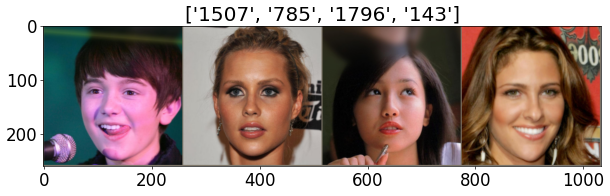

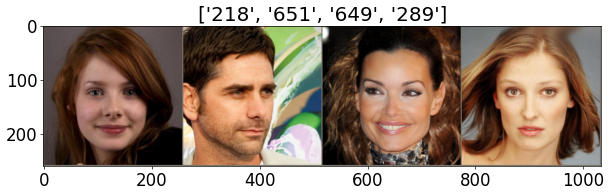

In [31]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 60
plt.rcParams.update({'font.size': 20})

# load a batch of train image
iterator = iter(train_dataloader)

# visualize a batch of train image
inputs, classes = next(iterator)
out = torchvision.utils.make_grid(inputs[:4])
imshow(out, title=[class_names[x] for x in classes[:4]])

# load a batch of test image
iterator = iter(test_dataloader)

# visualize a batch of test image
inputs, classes = next(iterator)
out = torchvision.utils.make_grid(inputs[:4])
imshow(out, title=[class_names[x] for x in classes[:4]])

## Fine-Tune FaceNet on CelebA-HQ

In [32]:
from facenet_pytorch import MTCNN, InceptionResnetV1
mtcnn = MTCNN(image_size=(args.image_size), device=device)
faceNet = InceptionResnetV1(pretrained='vggface2')

  0%|          | 0.00/107M [00:00<?, ?B/s]

In [33]:
# num_classes = len(identity_df.id.unique())
num_classes = len(class_names)
print(f'number of identities = {num_classes}, number of images = {len(train_dataset.imgs + test_dataset.imgs)}')

number of identities = 307, number of images = 5478


In [34]:
faceNet = set_parameter_requires_grad(faceNet, num_classes)
# new_resnet
params_to_update = []
for name,param in faceNet.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

optimizer = torch.optim.SGD(params_to_update, lr=args.lr, momentum=args.momentum)
criterion = nn.CrossEntropyLoss()

	 logits.weight
	 logits.bias


In [ ]:
train_losses, test_losses, train_acc, test_acc = train(faceNet, criterion, optimizer, args.train_celebA_num_epochs, train_dataloader, train_dataset, test_dataloader, test_dataset, args.model_path, with_aug=False)

267it [01:34,  2.83it/s]

[Train #0] Loss: 4.9601 Acc: 16.5611% Time: 94.3999s


[Test #0] Loss: 3.8560 Acc: 56.5432% Time: 116.5202s
==> Saving model ...


267it [01:25,  3.14it/s]

[Train #1] Loss: 3.1922 Acc: 68.8248% Time: 202.0524s


[Test #1] Loss: 2.4004 Acc: 85.5967% Time: 224.0642s
==> Saving model ...


267it [01:20,  3.31it/s]

[Train #2] Loss: 2.0194 Acc: 88.3650% Time: 305.0507s


[Test #2] Loss: 1.5327 Acc: 92.0988% Time: 327.1764s
==> Saving model ...


267it [01:22,  3.23it/s]

[Train #3] Loss: 1.3430 Acc: 94.2294% Time: 410.1890s


[Test #3] Loss: 1.0388 Acc: 94.4856% Time: 432.6585s
==> Saving model ...


267it [01:26,  3.09it/s]

[Train #4] Loss: 0.9680 Acc: 95.4961% Time: 519.4834s


[Test #4] Loss: 1.0560 Acc: 94.1564% Time: 543.3953s
==> Saving model ...


267it [01:23,  3.20it/s]

[Train #5] Loss: 0.7609 Acc: 96.2702% Time: 627.3830s


[Test #5] Loss: 0.6639 Acc: 96.2963% Time: 650.2252s
==> Saving model ...


267it [01:24,  3.17it/s]

[Train #6] Loss: 0.6166 Acc: 96.5986% Time: 734.8418s


[Test #6] Loss: 0.5453 Acc: 96.7078% Time: 757.5933s
==> Saving model ...


267it [01:26,  3.10it/s]

[Train #7] Loss: 0.5086 Acc: 97.5604% Time: 844.1438s


[Test #7] Loss: 0.4532 Acc: 97.2016% Time: 867.8948s
==> Saving model ...


267it [01:25,  3.12it/s]

[Train #8] Loss: 0.4855 Acc: 96.5283% Time: 953.9626s


[Test #8] Loss: 0.4066 Acc: 97.0370% Time: 978.0389s
==> Saving model ...


267it [01:25,  3.12it/s]

[Train #9] Loss: 0.3898 Acc: 97.7011% Time: 1064.1777s


[Test #9] Loss: 0.3699 Acc: 97.0370% Time: 1087.2667s
==> Saving model ...


267it [01:22,  3.22it/s]

[Train #10] Loss: 0.3854 Acc: 97.3258% Time: 1170.6419s


[Test #10] Loss: 0.3427 Acc: 97.1193% Time: 1193.1998s
==> Saving model ...


267it [01:21,  3.27it/s]

[Train #11] Loss: 0.3560 Acc: 97.3727% Time: 1275.2265s


[Test #11] Loss: 0.3265 Acc: 97.1193% Time: 1298.2378s
==> Saving model ...


267it [01:23,  3.22it/s]

[Train #12] Loss: 0.2958 Acc: 98.2407% Time: 1381.6804s


[Test #12] Loss: 0.3046 Acc: 97.3663% Time: 1403.6814s
==> Saving model ...


267it [01:19,  3.37it/s]

[Train #13] Loss: 0.3057 Acc: 97.7246% Time: 1483.3530s


[Test #13] Loss: 0.2927 Acc: 97.3663% Time: 1506.7396s
==> Saving model ...


267it [01:17,  3.43it/s]

[Train #14] Loss: 0.2720 Acc: 97.9826% Time: 1585.0085s


[Test #14] Loss: 0.2745 Acc: 97.6132% Time: 1606.7409s
==> Saving model ...


267it [01:18,  3.41it/s]

[Train #15] Loss: 0.2622 Acc: 97.8888% Time: 1685.4382s


[Test #15] Loss: 0.3054 Acc: 97.0370% Time: 1706.8505s
==> Saving model ...


267it [01:16,  3.51it/s]

[Train #16] Loss: 0.2587 Acc: 97.6073% Time: 1783.3457s


[Test #16] Loss: 0.2679 Acc: 97.2840% Time: 1804.6908s
==> Saving model ...


267it [01:17,  3.45it/s]

[Train #17] Loss: 0.2354 Acc: 98.1938% Time: 1882.4193s


[Test #17] Loss: 0.2473 Acc: 97.3663% Time: 1903.4460s
==> Saving model ...


267it [01:15,  3.55it/s]

[Train #18] Loss: 0.2046 Acc: 98.7802% Time: 1979.0546s


[Test #18] Loss: 0.2328 Acc: 97.5309% Time: 2001.4148s
==> Saving model ...


267it [01:15,  3.53it/s]

[Train #19] Loss: 0.1953 Acc: 98.5691% Time: 2077.5362s


[Test #19] Loss: 0.3235 Acc: 96.1317% Time: 2098.8121s
==> Saving model ...
==> Finished Training ...


##Plot and save test and train loss + accuracy

In [ ]:
test_acc_array = np.array([t.cpu().item() for t in test_acc])
train_acc_array = np.array([t.cpu().item() for t in train_acc])
test_losses = np.array(test_losses)
train_losses = np.array(train_losses)

np.save(args.model_path + r'/models/test_acc_array.npy', test_acc_array)
np.save(args.model_path + r'/models/train_acc_array.npy', train_acc_array)
np.save(args.model_path + r'/models/test_losses.npy', test_losses)
np.save(args.model_path + r'/models/train_losses.npy', train_losses)

In [38]:
# if nessecary
test_acc_array = np.load(args.model_path + r'/models/test_acc_array.npy')
train_acc_array = np.load(args.model_path + r'/models/train_acc_array.npy')
test_losses = np.load(args.model_path + r'/models/test_losses.npy')
train_losses = np.load(args.model_path + r'/models/train_losses.npy')

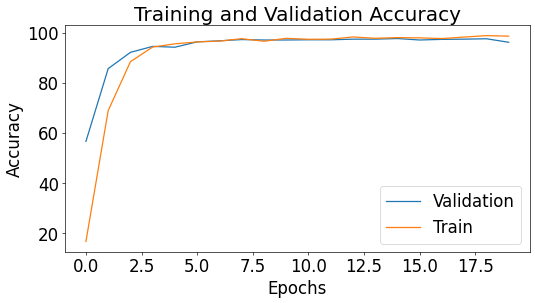

In [39]:
plt.figure(figsize=(10,5))
plt.title("Training and Validation Accuracy")
plt.plot(test_acc_array,label="Validation")
plt.plot(train_acc_array,label="Train")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

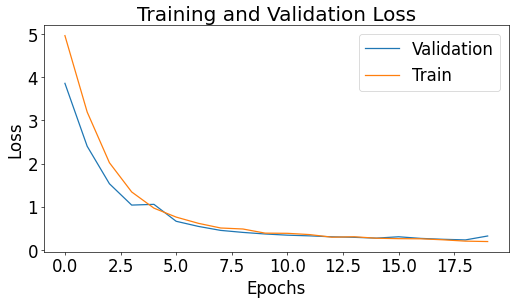

In [40]:
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(test_losses,label="Validation")
plt.plot(train_losses,label="Train")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


## Visualize evaluation on the trained FaceNet model:

In [ ]:
num_classes = len(class_names) # clebA HQ sub dataset
# print(num_classes)
from facenet_pytorch import MTCNN, InceptionResnetV1
celebA_facenet = InceptionResnetV1(pretrained='vggface2').to(device)
celebA_facenet = set_parameter_requires_grad(celebA_facenet, num_classes)

model_name = 'CelebA_HQ_Facenet_without_aug.pth'

state = torch.load(f'{args.model_path}models/{model_name}', map_location=device)
celebA_facenet.load_state_dict(state['net'])
celebA_facenet = celebA_facenet.to(device)
celebA_facenet.classify = True
celebA_facenet.eval()

## check 1 image clasification (verify FaceNet)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


real class = 17


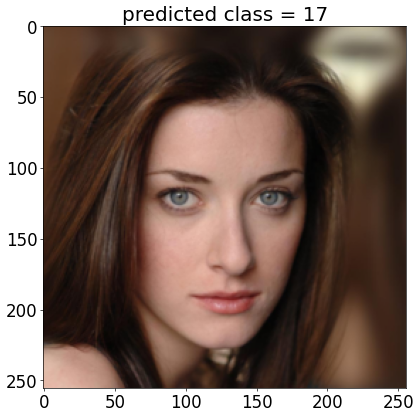

In [47]:
iterator = iter(test_dataloader)
inputs, classes = next(iterator)
img_probs = celebA_facenet(inputs.to(device))
out2 = torchvision.utils.make_grid(inputs[0])
print(f'real class = {class_names[classes[0]]}')
imshow(out2, title=f'predicted class = {class_names[img_probs.argmax(axis=1)[0].item()]}') # title=[x for x in img_probs.argmax(axis=1)]

## Visualize the possible augmentation attack

In [48]:
example_img_path = './CelebA_HQ_facial_identity_dataset/test/1989/7701.jpg' # ID = 1989
test_img = Image.open(example_img_path).convert('RGB')
test_img_attack2 = transforms_attack2(test_img)
test_img_attack3 = transforms_attack3(test_img)
orig_test_img = transforms_orig(test_img)

input = torch.stack([orig_test_img, test_img_attack2, test_img_attack3])

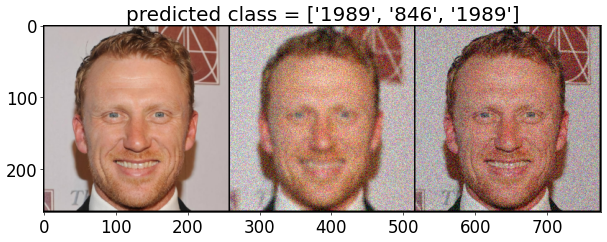

In [49]:
img_probs = celebA_facenet(input.to(device))
out0 = torchvision.utils.make_grid(input)
imshow_no_normalization(out0, title=f'predicted class = {[class_names[prob.argmax().item()] for prob in img_probs]}') # title=[x for x in img_probs.argmax(axis=1)]

## Add the augmented images to the dataset

In [ ]:
for filepath in glob.glob("/content/CelebA_HQ_facial_identity_dataset/train/*/"):
    for img_path in glob.glob(filepath + '/*'):
      test_img = Image.open(img_path).convert('RGB')
      test_img_attack2 = transforms_attack2(test_img)
      test_img_attack3 = transforms_attack3(test_img)
      torchvision.utils.save_image(test_img_attack2, img_path.split('.jpg')[0] + '_1.jpg')
      torchvision.utils.save_image(test_img_attack3,  img_path.split('.jpg')[0] + '_2.jpg')


In [55]:
for filepath in glob.glob("./CelebA_HQ_facial_identity_dataset/test/*/"):
    for img_path in glob.glob(filepath + '/*'):
      test_img = Image.open(img_path).convert('RGB')
      test_img_attack2 = transforms_attack2(test_img)
      test_img_attack3 = transforms_attack3(test_img)
      torchvision.utils.save_image(test_img_attack2, img_path.split('.jpg')[0] + '_1.jpg')
      torchvision.utils.save_image(test_img_attack3,  img_path.split('.jpg')[0] + '_2.jpg')

## check accuracy on the augmented test set

In [59]:
data_dir = './CelebA_HQ_facial_identity_dataset'
aug_train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transforms_train)
aug_test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'test'), transforms_test)

aug_train_dataloader = torch.utils.data.DataLoader(aug_train_dataset, batch_size=args.batch_size, shuffle=True, num_workers=args.num_workers)
aug_test_dataloader = torch.utils.data.DataLoader(aug_test_dataset, batch_size=args.batch_size, shuffle=True, num_workers=args.num_workers)


In [ ]:
print("evaluate FaceNet trained on regular data:")
eval_acc(celebA_facenet, test_dataloader, device)

print("evaluate FaceNet trained on augmented data:")
eval_acc(celebA_facenet, aug_test_dataloader, device)

evaluate on regular data:
Loss: 3.7225 Acc: 97.4507% 
evaluate on augmented data:
Loss: 19.7803 Acc: 75.6031% 


(19.780325496405887, tensor(75.6031, device='cuda:0'))

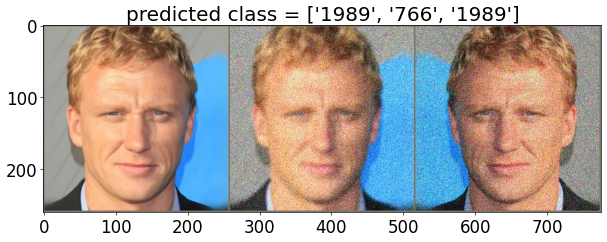

In [ ]:
# visualize the identification error
example_img_path = '/content/CelebA_HQ_facial_identity_dataset/test/1989/' # ID = 1989

test_img = transforms_orig(Image.open(example_img_path + '9308.jpg').convert('RGB'))
test_img_attack2 = transforms_orig(Image.open(example_img_path + '9308_1.jpg').convert('RGB'))
test_img_attack3 = transforms_orig(Image.open(example_img_path + '9308_2.jpg').convert('RGB'))

input = torch.stack([test_img, test_img_attack2, test_img_attack3])
img_probs = celebA_facenet(input.to(device))
out0 = torchvision.utils.make_grid(input)
[class_names[prob.argmax().item()] for prob in img_probs]
imshow(out0, title=f'predicted class = {[class_names[prob.argmax().item()] for prob in img_probs]}')

## Retrain the fine-tuned (on CelebA) faceNet on augmented data

In [ ]:
params_to_update = []
for name,param in celebA_facenet.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)
        
#same optimizer and criterion
optimizer = torch.optim.SGD(params_to_update, lr=args.lr, momentum=args.momentum)
criterion = nn.CrossEntropyLoss()

	 logits.weight
	 logits.bias


In [ ]:
aug_train_losses, aug_test_losses, aug_train_acc, aug_test_acc = train(celebA_facenet, criterion, optimizer, args.train_aug_celebA_num_epochs, aug_train_dataloader, aug_train_dataset, aug_test_dataloader, aug_test_dataset, args.model_path, with_aug=True, device=device)


800it [01:54,  6.96it/s]

[Train #0] Loss: 0.7622 Acc: 88.0835% Time: 116.0200s


[Test #0] Loss: 0.6163 Acc: 91.4129% Time: 149.5990s
==> Saving model ...


800it [02:09,  6.19it/s]

[Train #1] Loss: 0.6768 Acc: 89.2095% Time: 280.1415s


[Test #1] Loss: 0.6105 Acc: 90.8642% Time: 313.0978s
==> Saving model ...


800it [01:58,  6.74it/s]

[Train #2] Loss: 0.5877 Acc: 90.5153% Time: 433.1794s


[Test #2] Loss: 0.5180 Acc: 91.8793% Time: 466.0447s
==> Saving model ...


800it [01:55,  6.93it/s]

[Train #3] Loss: 0.5553 Acc: 90.7811% Time: 582.9014s


[Test #3] Loss: 0.6156 Acc: 89.7394% Time: 615.5020s
==> Saving model ...


800it [02:00,  6.61it/s]

[Train #4] Loss: 0.5144 Acc: 91.3754% Time: 737.8042s


[Test #4] Loss: 0.4629 Acc: 92.2908% Time: 770.6518s
==> Saving model ...
==> Finished Training ...


In [ ]:
aug_test_acc = np.array([t.cpu().item() for t in aug_test_acc])
aug_train_acc = np.array([t.cpu().item() for t in aug_train_acc])
aug_test_losses = np.array(aug_test_losses)
aug_train_losses = np.array(aug_train_losses)

np.save(args.model_path + r'/models/aug_test_acc.npy', aug_test_acc)
np.save(args.model_path + r'/models/aug_train_acc.npy', aug_train_acc)
np.save(args.model_path + r'/models/aug_test_losses.npy', aug_test_losses)
np.save(args.model_path + r'/models/aug_train_losses.npy', aug_train_losses)

# if nessecary
aug_test_acc = np.load(args.model_path + r'/models/aug_test_acc.npy')
aug_train_acc = np.load(args.model_path + r'/models/aug_train_acc.npy')
aug_test_losses = np.load(args.model_path + r'/models/aug_test_losses.npy')
aug_train_losses = np.load(args.model_path + r'/models/aug_train_losses.npy')

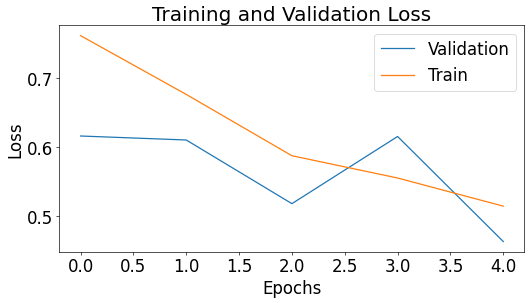

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(aug_test_losses,label="Validation")
plt.plot(aug_train_losses,label="Train")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


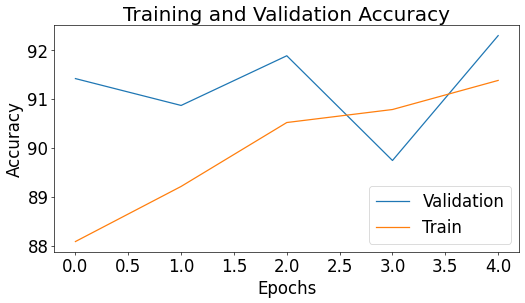

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Training and Validation Accuracy")
plt.plot(aug_test_acc,label="Validation")
plt.plot(aug_train_acc,label="Train")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

## compare old vs new (trained) network

In [50]:
from facenet_pytorch import MTCNN, InceptionResnetV1
celebA_facenet_old = InceptionResnetV1(pretrained='vggface2').to(device)
celebA_facenet_old = set_parameter_requires_grad(celebA_facenet_old, num_classes)

model_name = 'CelebA_HQ_Facenet_without_aug.pth'
state = torch.load(f'{args.model_path}/models/{model_name}', map_location=device)
celebA_facenet_old.load_state_dict(state['net'])
celebA_facenet_old = celebA_facenet_old.to(device)
celebA_facenet_old.eval()
celebA_facenet_old.classify = True

In [51]:
from facenet_pytorch import MTCNN, InceptionResnetV1
celebA_facenet_new = InceptionResnetV1(pretrained='vggface2').to(device)
celebA_facenet_new = set_parameter_requires_grad(celebA_facenet_new, num_classes)

model_name = 'CelebA_HQ_Facenet_with_aug_fine_tune.pth'
state = torch.load(f'{args.model_path}/models/{model_name}', map_location=device)
celebA_facenet_new.load_state_dict(state['net'])
celebA_facenet_new = celebA_facenet_new.to(device)
celebA_facenet_new.eval()
celebA_facenet_new.classify = True

In [ ]:
print("evaluate on fine-tuned not augmented data:")
eval_acc(celebA_facenet_old, aug_test_dataloader, device)

print("evaluate on fine-tuned augmented data:")
eval_acc(celebA_facenet_new, aug_test_dataloader, device)


evaluate on fine-tuned not augmented data:
Loss: 19.7008 Acc: 75.7127% 
evaluate on fine-tuned augmented data:
Loss: 8.0147 Acc: 90.4879% 


(8.014650075320612, tensor(90.4879, device='cuda:0'))

Old FaceNet:


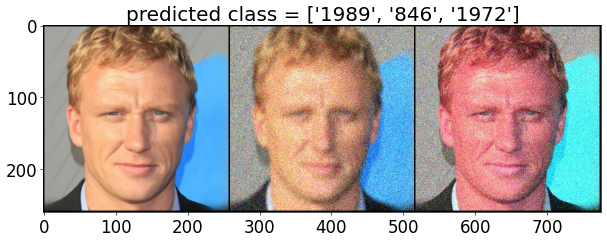

New FaceNet:


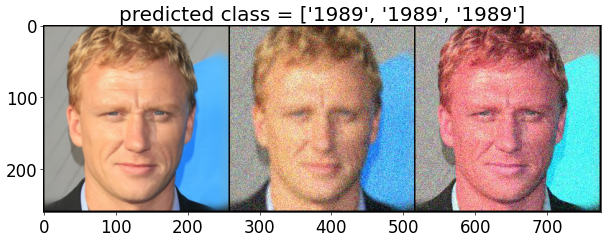

In [57]:
# visualize the identification error
example_img_path = '/content/CelebA_HQ_facial_identity_dataset/test/1027/5967.jpg' # ID = 1047
example_img_path = '/content/CelebA_HQ_facial_identity_dataset/test/1047/5967_1.jpg' # ID = 1047

test_img = transforms_orig(Image.open('./CelebA_HQ_facial_identity_dataset/test/1989/9308.jpg').convert('RGB'))
test_img_attack2 = transforms_orig(Image.open('./CelebA_HQ_facial_identity_dataset/test/1989/9308_1.jpg').convert('RGB'))
test_img_attack3 = transforms_orig(Image.open('./CelebA_HQ_facial_identity_dataset/test/1989/9308_2.jpg').convert('RGB'))
# test_img_attack4 = transforms_attack4(test_img)

print("Old FaceNet:")
input = torch.stack([test_img, test_img_attack2, test_img_attack3])
img_probs = celebA_facenet_old(input.to(device))
out0 = torchvision.utils.make_grid(input)
[class_names[prob.argmax().item()] for prob in img_probs]
imshow_no_normalization(out0, title=f'predicted class = {[class_names[prob.argmax().item()] for prob in img_probs]}')
print("New FaceNet:")
img_probs = celebA_facenet_new(input.to(device))
out0 = torchvision.utils.make_grid(input)
[class_names[prob.argmax().item()] for prob in img_probs]
imshow_no_normalization(out0, title=f'predicted class = {[class_names[prob.argmax().item()] for prob in img_probs]}')

##Train the fine-tuned on CelebA FaceNet on the data augmentations

In [ ]:
celebA_facenet_aug_from_scratch = InceptionResnetV1(pretrained='vggface2').to(device)
celebA_facenet_aug_from_scratch = set_parameter_requires_grad(celebA_facenet_aug_from_scratch, num_classes)
params_to_update1 = get_params_to_update(celebA_facenet_aug_from_scratch)
optimizer1 = torch.optim.SGD(params_to_update1, lr=args.lr, momentum=args.momentum)
criterion = nn.CrossEntropyLoss()


	 logits.weight
	 logits.bias


In [ ]:
aug_train_losses_scratch, aug_test_losses_scratch, aug_train_acc_scratch, aug_test_acc_scratch = train(celebA_facenet_aug_from_scratch, criterion, optimizer1, 
                                                                       args.train_celebA_num_epochs, aug_train_dataloader, aug_train_dataset, aug_test_dataloader,
                                                                        aug_test_dataset, args.model_path, with_aug=True, free_text='scratch')


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
800it [01:59,  6.68it/s]

[Train #0] Loss: 4.0751 Acc: 37.2195% Time: 121.2150s


[Test #0] Loss: 2.4462 Acc: 76.9822% Time: 158.8683s
==> Saving model ...


800it [01:55,  6.94it/s]

[Train #1] Loss: 1.8860 Acc: 80.7335% Time: 275.6528s


[Test #1] Loss: 1.2602 Acc: 88.9986% Time: 308.6861s
==> Saving model ...


800it [01:57,  6.83it/s]

[Train #2] Loss: 1.1592 Acc: 88.0601% Time: 427.2576s


[Test #2] Loss: 1.1940 Acc: 84.4993% Time: 460.0641s
==> Saving model ...


800it [01:54,  6.96it/s]

[Train #3] Loss: 0.8917 Acc: 89.5613% Time: 576.2702s


[Test #3] Loss: 0.7313 Acc: 91.4952% Time: 609.1120s
==> Saving model ...


800it [01:57,  6.80it/s]

[Train #4] Loss: 0.7239 Acc: 90.7655% Time: 728.1245s


[Test #4] Loss: 0.6217 Acc: 91.6872% Time: 760.7020s
==> Saving model ...


800it [01:54,  6.99it/s]

[Train #5] Loss: 0.6456 Acc: 91.1252% Time: 876.5691s


[Test #5] Loss: 0.5794 Acc: 91.6598% Time: 909.3880s
==> Saving model ...


800it [01:56,  6.85it/s]

[Train #6] Loss: 0.5784 Acc: 91.7507% Time: 1027.5504s


[Test #6] Loss: 0.5412 Acc: 92.0988% Time: 1060.0592s
==> Saving model ...


800it [01:54,  7.00it/s]

[Train #7] Loss: 0.5399 Acc: 91.8133% Time: 1175.7055s


[Test #7] Loss: 0.8755 Acc: 84.1975% Time: 1208.3464s
==> Saving model ...


800it [01:56,  6.84it/s]

[Train #8] Loss: 0.5065 Acc: 92.1339% Time: 1326.6978s


[Test #8] Loss: 0.5463 Acc: 91.4129% Time: 1359.2263s
==> Saving model ...


800it [01:53,  7.03it/s]

[Train #9] Loss: 0.4908 Acc: 92.1104% Time: 1474.4245s


[Test #9] Loss: 0.8425 Acc: 84.5267% Time: 1506.8340s
==> Saving model ...


800it [01:56,  6.86it/s]

[Train #10] Loss: 0.4573 Acc: 92.2746% Time: 1624.7942s


[Test #10] Loss: 0.4436 Acc: 92.5652% Time: 1657.3467s
==> Saving model ...


800it [01:53,  7.03it/s]

[Train #11] Loss: 0.4571 Acc: 92.2590% Time: 1772.4330s


[Test #11] Loss: 0.7648 Acc: 85.2675% Time: 1804.9904s
==> Saving model ...


800it [01:56,  6.87it/s]

[Train #12] Loss: 0.4044 Acc: 93.0409% Time: 1922.8164s


[Test #12] Loss: 0.4567 Acc: 92.1811% Time: 1955.0512s
==> Saving model ...


800it [01:55,  6.93it/s]

[Train #13] Loss: 0.4063 Acc: 92.8611% Time: 2071.7991s


[Test #13] Loss: 0.7091 Acc: 85.7613% Time: 2105.9933s
==> Saving model ...


800it [01:54,  6.97it/s]

[Train #14] Loss: 0.3862 Acc: 93.2833% Time: 2222.1108s


[Test #14] Loss: 0.4537 Acc: 91.9342% Time: 2254.4088s
==> Saving model ...


800it [02:13,  5.97it/s]

[Train #15] Loss: 0.4006 Acc: 92.8532% Time: 2389.5965s


[Test #15] Loss: 0.4226 Acc: 92.3731% Time: 2422.0641s
==> Saving model ...


800it [01:54,  6.98it/s]

[Train #16] Loss: 0.3842 Acc: 93.1034% Time: 2538.0733s


[Test #16] Loss: 0.4291 Acc: 92.1262% Time: 2570.3110s
==> Saving model ...


800it [01:57,  6.83it/s]

[Train #17] Loss: 0.3768 Acc: 93.0331% Time: 2688.9104s


[Test #17] Loss: 0.4201 Acc: 91.7695% Time: 2721.6117s
==> Saving model ...


800it [01:54,  6.97it/s]

[Train #18] Loss: 0.3638 Acc: 93.2833% Time: 2837.7566s


[Test #18] Loss: 0.3940 Acc: 92.5926% Time: 2870.0340s
==> Saving model ...


800it [01:55,  6.92it/s]

[Train #19] Loss: 0.3614 Acc: 93.3537% Time: 2986.9735s


[Test #19] Loss: 0.3878 Acc: 92.4006% Time: 3019.4432s
==> Saving model ...
==> Finished Training ...


In [ ]:
# save the train / test accuracy and loss - for later usage 
aug_test_acc_scratch = np.array([t.cpu().item() for t in aug_test_acc_scratch])
aug_train_acc_scratch = np.array([t.cpu().item() for t in aug_train_acc_scratch])
aug_test_losses_scratch = np.array(aug_test_losses_scratch)
aug_train_losses_scratch = np.array(aug_train_losses_scratch)

np.save(args.model_path + r'/models/aug_test_acc_scratch.npy', aug_test_acc_scratch)
np.save(args.model_path + r'/models/aug_train_acc_scratch.npy', aug_train_acc_scratch)
np.save(args.model_path + r'/models/aug_test_losses_scratch.npy', aug_test_losses_scratch)
np.save(args.model_path + r'/models/aug_train_losses_scratch.npy', aug_train_losses_scratch)

# if nessecary
aug_test_acc_scratch = np.load(args.model_path + r'/models/aug_test_acc_scratch.npy')
aug_train_acc_scratch = np.load(args.model_path + r'/models/aug_train_acc_scratch.npy')
aug_test_losses_scratch = np.load(args.model_path + r'/models/aug_test_losses_scratch.npy')
aug_train_losses_scratch = np.load(args.model_path + r'/models/aug_train_losses_scratch.npy')

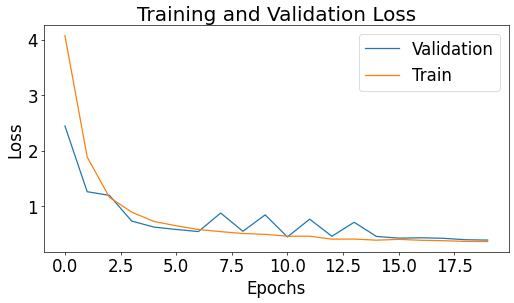

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(aug_test_losses_scratch,label="Validation")
plt.plot(aug_train_losses_scratch,label="Train")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


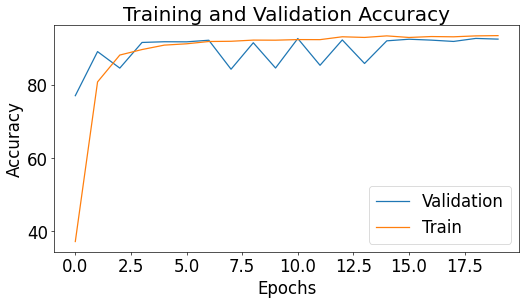

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Training and Validation Accuracy")
plt.plot(aug_test_acc_scratch,label="Validation")
plt.plot(aug_train_acc_scratch,label="Train")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [58]:
from facenet_pytorch import MTCNN, InceptionResnetV1
celebA_facenet_scratch = InceptionResnetV1(pretrained='vggface2').to(device)
celebA_facenet_scratch = set_parameter_requires_grad(celebA_facenet_scratch, num_classes)

model_name = 'CelebA_HQ_Facenet_with_aug_scratch.pth'
state = torch.load(f'{args.model_path}/models/{model_name}', map_location=device)
celebA_facenet_scratch.load_state_dict(state['net'])
celebA_facenet_scratch = celebA_facenet_scratch.to(device)

In [60]:
print("evaluate on fine-tuned not augmented data:")
eval_acc(celebA_facenet_old, aug_test_dataloader, device)

print("evaluate on fine-tuned  CelebA  + fine-tuned augmented data:")
eval_acc(celebA_facenet_new, aug_test_dataloader, device)

print("evaluate on fine-tuned augmented data from scratch:")
eval_acc(celebA_facenet_scratch, aug_test_dataloader, device)

evaluate on fine-tuned not augmented data:
Loss: 20.0948 Acc: 74.8904% 
evaluate on fine-tuned  CelebA  + fine-tuned augmented data:
Loss: 7.2834 Acc: 92.2423% 
evaluate on fine-tuned augmented data from scratch:
Loss: 6.9370 Acc: 92.6261% 


(6.937003867210526, tensor(92.6261, device='cuda:0'))